In [1]:
import sqlite3
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import chi2_contingency

connect = sqlite3.connect('lessons.sqlite')

# Задание
Мы хотим снизить стоимость одного из наших продуктов с 400 у.е. до 160 у.е. Необходимо:
[ ] Задизайнить эксперимент. В качестве ключевой метрики – взять конверсию в платящего;
[ ] Датасет можно исследовать на всех данных, а дизайнить АБ на контрольной группе;
[ ] Проанализировать результаты;
[ ] Подготовить мини-презентацию результатов;

# Данные
__actions__ – данные о совершаемых пользователем событиях:
- uid – идентификатор пользователя; 
- ts – время совершения события; 
- action – название события, где `firstOpen` – первое открытие приложения после установки, `function%` – использование какой-либо функции приложения; 

__experiments__ – данные о принодлежности пользователя к группам эксперимента. Один пользователь может быть в нескольких экспериментах одновременно:
- experimetn – название эксперимента;
- group – группа в эксперименте (old = control, new = test);
- uid – идентификатор пользователя; 

__payments__ – данные о покупках пользователей. В сервисе есть два типа покупок (товаров), которые могут быть осуществлены одновременно:
- uid – идентификатор пользователя;
- payment_type – тип покупки;
- payment – платеж, который пришел в сервис;  


# Решение

## Загружаем данные 

In [2]:
# Выберем только тех пользователей, которые принимали участие в анализируемом нами АБ (paymentChange)
sql = """
with
    users_labels as (
        select
            experiment,
            uid,
            count(distinct(group_label)) as uniq_group_cnt,
            json_group_array(distinct(group_label)) as uniq_group_label
        from ab_experiments
        where experiment == 'paymentChange'
        group by  experiment, uid
    ),

    users_payments as (
        select
            uid,
            json_group_array(payment_type) as arr_payment_type,
            json_group_array(payment) as arr_payment,
            count(distinct payment) as uniq_payment_cnt
        from ab_payments
        group by uid
    ),

    data as (
        select
            a.uid, a.ts, date(a.ts) as date, a.action,
            l.experiment, l.uniq_group_cnt, json_extract(l.uniq_group_label, '$[0]') as uniq_group_label,
            p.arr_payment_type, p.arr_payment,
            case when p.uniq_payment_cnt is null then 0 else p.uniq_payment_cnt end as uniq_payment_cnt,
            case when p.uniq_payment_cnt is null then 0 else 1 end as is_payment_uid
        from ab_actions as a
        left join users_labels as l on a.uid == l.uid
        left join users_payments as p on a.uid == p.uid
        order by a.uid, a.ts asc
    )

select * from data;
"""
df = pd.read_sql_query(sql, connect)
df['ts'] = pd.to_datetime(df['ts'])
df['date'] = pd.to_datetime(df['date'])

In [3]:
df.sample(5)

,uid,ts,date,action,experiment,uniq_group_cnt,uniq_group_label,arr_payment_type,arr_payment,uniq_payment_cnt,is_payment_uid
92420,mnbpj,2020-01-16 02:50:24,2020-01-16,firstOpen,paymentChange,1,control,"[""type2""]",[200],1,1
84013,ljtyv,2020-01-15 17:44:56,2020-01-15,function4,paymentChange,1,test,"[""type1""]",[160],1,1
106180,ojjdr,2020-01-17 02:39:01,2020-01-17,function2,paymentChange,1,control,"[""type2""]",[200],1,1
62072,ikwnm,2020-01-15 07:04:37,2020-01-15,function2,paymentChange,1,test,"[""type1""]",[160],1,1
17079,cggop,2020-01-14 09:00:44,2020-01-14,firstOpen,paymentChange,1,control,None,None,0,0


In [4]:
# Разделим данные на control/test 
control = df[df['uniq_group_label'] == 'control'].copy()
test = df[df['uniq_group_label'] == 'test'].copy()

## Изучаем "прошлое" по контрольной группе

In [5]:
# Наша цель – провести АБ на снижение стоимости продукта с 400 до 160.
# Так как пользователи могут покупать несколько продуктов и мы не можем восстановить хронологию (нет ts покупок), 
# то будем считать CR только по тем кто совершил единственную покупку по 400 
control.loc[control['arr_payment'] == '[400]', 'is_400'] = 1
control_pay = control.groupby('uid')['is_400'].max().fillna(0)
control_total = control_pay.shape[0]
control_400_users = control_pay[control_pay.values == 1].shape[0]
control_400_cr = control_pay.mean()
control_400_var = control_pay.var()

print(
    f'control_total: {control_total}, control_400_users: {control_400_users}',
    f'control_400_cr: {control_400_cr:.2%}, control_400_var: {control_400_var:.4f}'
)

# В какой-то итерации была попытка выяснить как последовательность действий (action) влияет на CR, но к успеху это не привело. 
# Единственное, что удалось выяснить, что пользователи весьма активно юзают все фичи (feature1,2,3,4). И эта активность не зависит от группы АБ и/или
# наличия/отсутствия статусу покупателя. 

control_total: 25001, control_400_users: 3118 control_400_cr: 12.47%, control_400_var: 0.1092


## Дизайн АБ
__Гипотеза__. Если мы уменьшим стоимость продукта с 400уе до 160уе, то это позволит увеличить долю платящих пользователей с CR 12.47% до 22.47% (+10%). Потому что продукт станет дешевле с сохранением своего функционала и полезности для пользователей. При этом мы возьмем для теста alpha=0.05, beta=0.2

__Сегментация ЦА__. Чтобы минимизировать возможное количество негатива от старых пользователей, будем предлагать новую цену (160уе) только тем пользователям, которые не покупали продукт за 400уе (Судя по данным именно это и было сделано). И чтобы избежать сетевого эффекта, будем анализировать только тех пользователей, которые совершили одну покупку за 400 в контрольной группе или за 160 в тестовой. 

__Длительность эксперимента и MDE__. 
Так как у нас все фиксированно (АБ уже прошел), то MDE посчитаем для всего временного периода АБ (12 дней). Сделаем это для того, чтобы понимать – хватает у нас "исторических" данных, чтобы зафиксировать желаемое изменение. 

In [103]:
# Для расчета MDE используем формулу и сразу подставим в нее "константу" для выбранных нами alpha/beta: -(Z_{alpha/2} +Z_{beta} = -2.802
z_score = -2.802
mde_absolute = (-1 * z_score) * (np.sqrt(4 * control_400_var / control_total))
mde_relative = (mde_absolute / control_400_cr * 100)
up_lift = control_400_cr * 0.1

print(f'mde_absolute: {mde_absolute:.4f}\n'
      f'mde_relative: {mde_relative:.2f}%\n'
      f'up_lift: {up_lift:.5f}')

# Отлично! За 12 дней мы сможем задетектить (с желаемой alpha/beta) стат.значимый прирост на +9.39% и выше.   
# Соответствующий абсолютный прирост будет равен 12.47% (CRhist) * 10% (CRwaiting) = 0.1247 

mde_absolute: 0.0117
mde_relative: 9.39%
up_lift: 0.01247


## Результаты АБ

In [8]:
# В данные с тестовой группой добавим (как и в контроль) явный признак, что пользователь сделал только одну покупку продукта за 160 
test.loc[test['arr_payment'] == '[160]', 'is_160'] = 1

# Объединим control и test в одни DataFrame (можно было и не разделять)
results = pd.concat([
    control[['uid', 'date', 'action', 'uniq_group_label', 'is_400']],
    test[['uid', 'date', 'action', 'uniq_group_label', 'is_160']]
])
results.fillna(0, inplace=True)

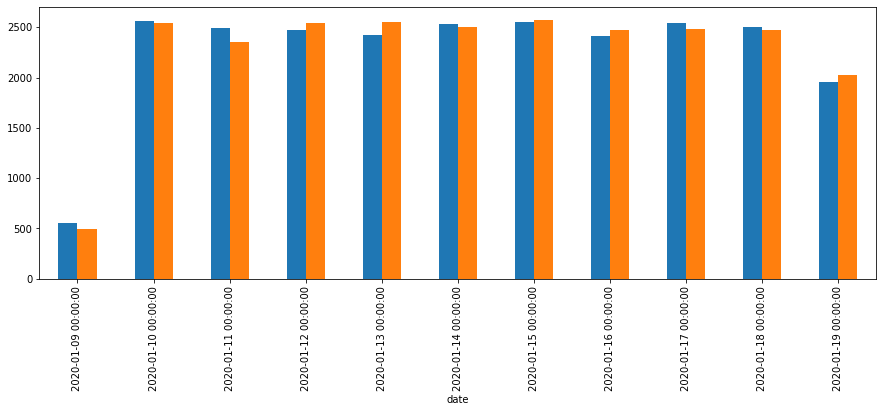

In [9]:
# Прежде чем переходить к анализу АБ сделаем несколько базовых проверок
# Проверим, равномерность наполнения групп в тесте
check_users = results[results['action'] == 'firstOpen'].pivot_table(index='date', columns='uniq_group_label',
                                                                    aggfunc={'uid': 'count'})
check_users.plot(kind='bar', figsize=(15, 5), legend=False);

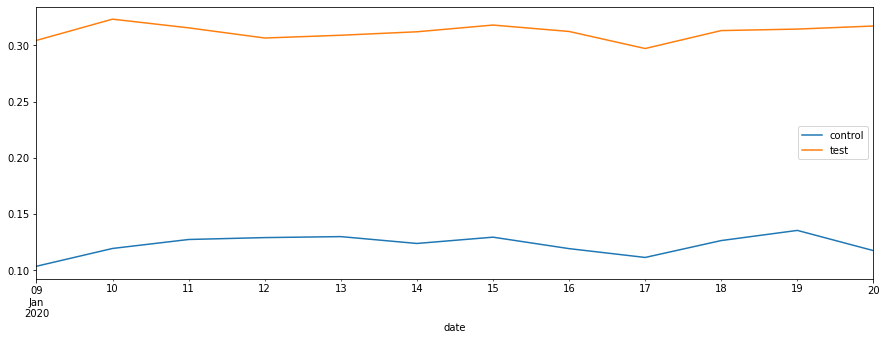

In [10]:
# Посмотрим ежедневную динамику CR, чтобы убедиться в отсутствии каких-то аномальных скачков. 
check_cr = results.pivot_table(index='date', columns='uniq_group_label',
                               aggfunc={'is_400': 'mean', 'is_160': 'mean'})

check_cr = pd.concat([check_cr.loc[:, 'is_400']['control'],
                      check_cr.loc[:, 'is_160']['test']], axis=1)

check_cr.plot(kind='line', figsize=(15, 5));

In [105]:
# Посчитаем метрики по контрольной группе и сравним их с тестовой
test_pay = test.groupby('uid')['is_160'].max().fillna(0)
test_total = test_pay.shape[0]
test_160_users = test_pay[test_pay.values == 1].shape[0]
test_160_cr = test_pay.mean()
test_160_var = test_pay.var()

print(
    f'group_a_400: total: {control_total}, success: {control_400_users}, cr: {control_400_cr:.2%}, var: {control_400_var:.4f}\n'
    f'group_b_160: total: {test_total}, success: {test_160_users}, cr: {test_160_cr:.2%}, var: {test_160_var:.4f}'
)

# Уф, кажется у нас успешный успех. Мы ожидали прирост в +10%, а получили сильно больше.


group_a_400: total: 25001, success: 3118, cr: 12.47%, var: 0.1092
group_b_160: total: 25000, success: 7791, cr: 31.16%, var: 0.2145


In [62]:
# Проведем стат.тест, чтобы подтвердить результаты 
alpha = 0.05
beta = 0.20

z_score, p_value_z = proportions_ztest(
    count=[control_400_users, test_160_users],
    nobs=[control_total, test_total],
    alternative='two-sided')

if p_value_z < alpha:
    res = "Статистически значимая разница в конверсиях между двумя группами (отвергаем нулевую гипотезу)."
else:
    res = "Нет статистически значимой разницы в конверсиях между двумя группами (не отвергаем нулевую гипотезу)."

# Отлично! Подтвердили, что разница в CR стат.значимая. 
print(f'z_score: {z_score}, p_value: {p_value_z}\n{res}')

z_score: -50.60215194500424, p_value: 0.0
Статистически значимая разница в конверсиях между двумя группами (отвергаем нулевую гипотезу).


In [83]:
# А давайте теперь еще и на деньги посмотрим. CR мы круто увеличили, но что по бизнесу?
print(f'group_a_400: pay_users: {control_400_users}, income: {control_400_users * 400:_} rub.\n'
      f'group_b_160: pay_users: {test_160_users}, income: {test_160_users * 160:_} rub.')

group_a_400: pay_users: 3118, income: 1_247_200 rub.
group_b_160: pay_users: 7791, income: 1_246_560 rub.


In [88]:
# Упс, как-то сильно больше денег не стало, но у нас же есть пользователи, которые купили несколько продуктов.
# Что если первая покупка за 160 увеличивает количество последующих покупок за 200?
# На имеющихся данных мы не можем точно ответить на этот вопрос, нужно узнать ts покупок.
# Но мы можем посмотреть размер/долю пользователей которые делали покупки [400,200] и [160,200]
# И увидим, что в тестовой группе доля покупающих второй раз сильно больше. Стоит детальнее исследовать данный вопрос.
control_400_200_users = df[df['arr_payment'] == '[400,200]']['uid'].nunique()
test_160_200_users = df[df['arr_payment'] == '[160,200]']['uid'].nunique()

print(f'group_a_400_200: pay_users: {control_400_200_users}, percent: {control_400_200_users / control_total:.2%}\n'
      f'group_b_160_200: pay_users: {test_160_200_users}, percent: {test_160_200_users / test_total:.2%}')

group_a_400_200: pay_users: 1850, percent: 7.40%
group_b_160_200: pay_users: 4678, percent: 18.71%


In [96]:
x = df[(df['arr_payment']=='[400]')&(df['uniq_group_label']=='control')]['uid'].nunique()
y = df[(df['arr_payment']=='[200]')&(df['uniq_group_label']=='control')]['uid'].nunique()
xy = df[(df['arr_payment']=='[400,200]')&(df['uniq_group_label']=='control')]['uid'].nunique()

In [99]:
x / control_total 

0.12471501139954402

In [100]:
y / control_total

0.29770809167633294

In [102]:
xy / control_total * 100

7.3997040118395265